# Drone Trajectory Planner

In this project, we will develop the drone trajectory planner. This notebook serves as the main file for the project, where we will refer to the instructions and demonstrate our code.

Please follow week by week instructions, which includes writing the code in the `src/` folder.

In [1]:
# Import all the files and libraries required for the project
%load_ext autoreload
%autoreload 2
import copy
    
import numpy as np

from src.camera_utils import compute_image_footprint_on_surface, compute_ground_sampling_distance, project_world_point_to_image, reproject_image_point_to_world
from src.data_model import Camera, DatasetSpec
from src.plan_computation import compute_distance_between_images, compute_speed_during_photo_capture, generate_photo_plan_on_grid
from src.visualization import plot_photo_plan

# Week 1: Introduction

No code contribution expected this week

# Week 2: Camera System Modeling and Operations

We plan to
- Model the simple pinhole camera system
- Write utility functions to
    - project a 3D world point to an image
    - Compute image footprint on a surface
    - Compute the Ground Sampling Distance

## Model the camera parameters

We want to model the following camera parameters in Python:
- focal length along x axis (in pixels)
- focal length along y axis (in pixels)
- optical center of the image along the x axis (in pixels)
- optical center of the image along the y axis (in pixels)
- Size of the sensor along the x axis (in mm)
- Size of the sensor along the y axis (in mm)
- Number of pixels in the image along the x axis
- Number of pixels in the image along the y axis

I recommend to use `dataclasses` ([Python documentation](https://docs.python.org/3/library/dataclasses.html), [Blog](https://www.dataquest.io/blog/how-to-use-python-data-classes/) to model these parameters.

$\color{red}{\text{TODO: }}$ Implement `Camera` in `src/data_model.py`

In [2]:
# Define the parameters for Skydio VT300L - Wide camera
# Ref: https://support.skydio.com/hc/en-us/articles/20866347470491-Skydio-X10-camera-and-metadata-overview
fx = 4938.56
fy = 4936.49
cx = 4095.5
cy = 3071.5
sensor_size_x_mm = 13.107 # single pixel size * number of pixels in X dimension
sensor_size_y_mm = 9.830 # single pixel size * number of pixels in Y dimension
image_size_x = 8192
image_size_y = 6144

camera_x10 = Camera(fx, fy, cx, cy, sensor_size_x_mm, sensor_size_y_mm, image_size_x, image_size_y)

In [3]:
print(f"X10 camera model: {camera_x10}")

X10 camera model: Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144)


## Project 3D world points into the image


![Camera Projection](assets/image_projection.png)
Reference: [Robert Collins CSE483](https://www.cse.psu.edu/~rtc12/CSE486/lecture12.pdf)


Equations to implement:
$$ x = f_x \frac{X}{Z} $$
$$ y = f_y \frac{Y}{Z} $$
$$ u = x + c_x $$
$$ v = y + c_y $$

$\color{red}{\text{TODO: }}$ Implement function `project_world_point_to_image` in `src/camera_utils.py`

In [4]:
point_3d = np.array([25, -30, 50], dtype=np.float32)
expected_uv = np.array([6564.80, 109.60], dtype=np.float32)
uv = project_world_point_to_image(camera_x10, point_3d)

print(f"{point_3d} projected to {uv}")

assert np.allclose(uv, expected_uv, atol=1e-2)

[ 25. -30.  50.] projected to [6564.7803   109.60596]


## Compute Image Footprint on the surface

We have written code to *project* a 3D point into the image. The reverse operation is reprojection, where we take $(x, y)$ and compute the $(X, Y)$ for a given value of $Z$. Note that while going from 3D to 2D, the depth becomes ambiguous so we need the to specify the $Z$.

An image's footprint is the area on the surface which is captured by the image. We can take the two corners of the image and reproject them at a given distance to obtain the width and length of the image.

$\color{red}{\text{TODO: }}$ Implement function `compute_image_footprint_on_surface` in `src/camera_utils.py`

In [5]:
footprint_at_100m = compute_image_footprint_on_surface(camera_x10, 100)
expected_footprint_at_100m = np.array([165.88, 124.46], dtype=np.float32)

print(f"Footprint at 100m = {footprint_at_100m}")

assert np.allclose(footprint_at_100m, expected_footprint_at_100m, atol=1e-2)


Footprint at 100m = [165.87831271 124.46090238]


In [6]:
footprint_at_200m = compute_image_footprint_on_surface(camera_x10, 200)
expected_footprint_at_200m = expected_footprint_at_100m * 2

print(f"Footprint at 200m = {footprint_at_200m}")

assert np.allclose(footprint_at_200m, expected_footprint_at_200m, atol=1e-2)

Footprint at 200m = [331.75662541 248.92180476]


## Ground Sampling Distance

Ground sampling distance is the length of the ground (in m) captured by a single pixel. We have the image footpring (the dimensions of ground captured by the whole sensor, and the number of pixels along the horizontal and vertical dimension. Can we get GSD from these two quantities?

In [7]:
gsd_at_100m = compute_ground_sampling_distance(camera_x10, 100)
expected_gsd_at_100m = 0.0202

print(f"GSD at 100m: {gsd_at_100m}")

assert np.allclose(gsd_at_100m, expected_gsd_at_100m, atol=1e-4)

GSD at 100m: 0.020248817469059804


## Bonus: Reprojection from 2D to 3D

If we have a 2d pixel location of a point along with the camera model, can we go back to 3D?
Do we need any additional information.


$\color{red}{\text{TODO: }}$ Implement function `reproject_image_point_to_world` in `src/camera_utils.py` and demonstrate it by running it in the notebook. Confirm that your reprojection + projection function are consistent.

In [8]:
# We can reproject a 2D pixel location back to a 3D world point using the camera model.
# However, we need the depth (distance) of the point from the camera.
# The depth is necessary to determine the exact position in 3D space.

# Define a new 3D point
initial_3d_point = np.array([10.0, 20.0, 30.0])

# Project the 3D point to a 2D pixel location
projected_2d_image_point = project_world_point_to_image(camera_x10, initial_3d_point)

# Use the depth of the original 3D point to reproject the 2D pixel back to 3D
depth = initial_3d_point[2]
reprojected_3d_point = reproject_image_point_to_world(camera_x10, projected_2d_image_point, depth)

print("Initial 3D point:", initial_3d_point)
print("Converted 2D pixel location (uv):", uv)
print("Assumed depth:", depth)
print("Reprojected 3D world point:", reprojected_3d_point)

# Confirm consistency
assert np.allclose(initial_3d_point, reprojected_3d_point), "Reprojection and projection are not consistent"

Initial 3D point: [10. 20. 30.]
Converted 2D pixel location (uv): [6564.7803   109.60596]
Assumed depth: 30.0
Reprojected 3D world point: [10. 20. 30.]


# Week 3: Model the user requirements

For this week, we will model the dataset specifications.

- Overlap: the ratio (in 0 to 1) of scene shared between two consecutive images.
- Sidelap: the ratio (in 0 to 1) of scene shared between two images in adjacent rows.
- Height: the height of the scan above the ground (in meters).
- Scan_dimension_x: the horizontal size of the rectangle to be scanned
- Scan_dimension_y: the vertical size of the rectangle to be scanned
- exposure_time_ms: the exposure time for each image (in milliseconds).


$\color{red}{\text{TODO: }}$ Implement `DatasetSpec` in `src/data_model.py`


In [9]:
# Model the nomimal dataset spec

overlap = 0.7
sidelap = 0.7
height = 30.48 # 100 ft
scan_dimension_x = 150
scan_dimension_y = 150
exposure_time_ms = 2 # 1/500 exposure time

dataset_spec = DatasetSpec(overlap, sidelap, height, scan_dimension_x, scan_dimension_y, exposure_time_ms)

print(f"Nominal specs: {dataset_spec}")

Nominal specs: DatasetSpec(overlap=0.7, sidelap=0.7, height=30.48, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=2, gimbal_x_deg=0, gimbal_y_deg=0)


# Week 4: Compute Distance Between Photos

The overlap and sidelap are the ratio of the dimensions shared between two photos. We already know the footprint of a single image at a given distance. Can we convert the ratio into actual distances? And how does the distance on the surface relate to distance travelled by the camera?

$\color{red}{\text{TODO: }}$ Implement `compute_distance_between_images` in `src/plan_computation.py`



In [10]:
computed_distances = compute_distance_between_images(camera_x10, dataset_spec)
expected_distances = np.array([15.17, 11.38], dtype=np.float32)

print(f"Computed distance for X10 camera with nominal dataset specs: {computed_distances}")

assert np.allclose(computed_distances, expected_distances, atol=1e-2)

Computed distance for X10 camera with nominal dataset specs: [15.16791291 11.38070491]


$\color{red}{\text{TODO: }}$ define more specifications/camera parameters and check the computed distances. Does that align with your expections


In [11]:
# Height of the scan

new_dataset_spec = copy.copy(dataset_spec)
new_dataset_spec.height *= 2

new_computed_distances = compute_distance_between_images(camera_x10, new_dataset_spec)

print(f"Computed distance (original): {computed_distances}")
print(f"Computed distance (modified): {new_computed_distances}")

# if height of the scan is scaled by x, the distance between images will be scaled by x

Computed distance (original): [15.16791291 11.38070491]
Computed distance (modified): [30.33582583 22.76140983]


In [12]:
# Overlap and sidelap

new_dataset_spec = copy.copy(dataset_spec)
new_dataset_spec.overlap *= 0.3
new_dataset_spec.sidelap *= 0.5

new_computed_distances = compute_distance_between_images(camera_x10, new_dataset_spec)

print(f"Computed distance (original): {computed_distances}")
print(f"Computed distance (modified): {new_computed_distances}")
scaling_factor_x = (1 - new_dataset_spec.overlap) / (1 - overlap)
scaling_factor_y = (1 - new_dataset_spec.sidelap) / (1 - sidelap)
expected_modified_distances = computed_distances * np.array([scaling_factor_x, scaling_factor_y])
assert np.allclose(new_computed_distances, expected_modified_distances, atol=1e-2)

# if the overlap percentage is increased, the distance between images will be reduced

Computed distance (original): [15.16791291 11.38070491]
Computed distance (modified): [39.94217067 24.65819398]


In [13]:
# Focal length of camera

new_camera = copy.copy(camera_x10)
new_camera.fx *= 2
new_camera.fy *= 3

new_computed_distances = compute_distance_between_images(new_camera, dataset_spec)

print(f"Computed distance (original): {computed_distances}")
print(f"Computed distance (modified): {new_computed_distances}")
assert np.allclose(new_computed_distances, computed_distances / np.array([2, 3]), atol=1e-2)

# if the focal length is scaled by x, the distance between images will be scaled by 1/x

Computed distance (original): [15.16791291 11.38070491]
Computed distance (modified): [7.58395646 3.7935683 ]


## Bonus: Non-Nadir photos

We have solved for the distance assuming that the camera is facing straight down to the ground. This is called [Nadir scanning](https://support.esri.com/en-us/gis-dictionary/nadir). However, in practise we might want a custom gimbal angle.

Your bonus task is to make the distance computation general. Introduce the `camera_angle` parameter in the dataset specification, and work out how to adapt your computation. Feel free to reach out to Ayush to discuss ideas and assumptions!

The image below shows how non-nadir images are captured and how the footprint changes.
For futher reading, refer [How do I calculate the ground footprint of an aerial camera?](https://photo.stackexchange.com/questions/56596/how-do-i-calculate-the-ground-footprint-of-an-aerial-camera)

![Non Nadir](https://i.sstatic.net/oxuYA.png)

In [14]:
from copy import deepcopy
from src.camera_utils import compute_image_footprint_on_surface_with_gimbal_angle
from src.plan_computation import compute_distance_between_images_with_gimbal_angle

test_dataset_spec = deepcopy(dataset_spec)
test_dataset_spec.gimbal_x_deg = 20
test_dataset_spec.gimbal_y_deg = 20

image_footprint_without_gimbal = compute_image_footprint_on_surface(camera_x10, test_dataset_spec.height)
image_footprint_with_gimbal = compute_image_footprint_on_surface_with_gimbal_angle(camera_x10, test_dataset_spec.height, test_dataset_spec.gimbal_x_deg, test_dataset_spec.gimbal_y_deg)
print(f"Image footprint without gimbal: {image_footprint_without_gimbal}")
print(f"Image footprint with gimbal: {image_footprint_with_gimbal}")

print()

distance_between_images_without_gimbal = compute_distance_between_images(camera_x10, test_dataset_spec)
distance_between_images_with_gimbal = compute_distance_between_images_with_gimbal_angle(camera_x10, test_dataset_spec)
print(f"Distance between images without gimbal: {distance_between_images_without_gimbal}")
print(f"Distance between images with gimbal: {distance_between_images_with_gimbal}")

# The image footprint and distance between images are affected by the gimbal angles.
# As the gimbal angles increase, the image footprint becomes larger and the distance between images becomes larger.

# for testing/validation purposes
# check if the image footprint and distance between images are consistent when the gimbal angles are zero
image_footprint_with_gimbal_as_zero = compute_image_footprint_on_surface_with_gimbal_angle(camera_x10, dataset_spec.height, dataset_spec.gimbal_x_deg, dataset_spec.gimbal_y_deg)
assert np.allclose(image_footprint_with_gimbal_as_zero, image_footprint_without_gimbal, atol=1e-2)

distance_between_images_with_gimbal_as_zero = compute_distance_between_images_with_gimbal_angle(camera_x10, dataset_spec)
assert np.allclose(distance_between_images_with_gimbal_as_zero, distance_between_images_without_gimbal, atol=1e-2)

Image footprint without gimbal: [50.55970971 37.93568305]
Image footprint with gimbal: [62.99848811 45.28438466]

Distance between images without gimbal: [15.16791291 11.38070491]
Distance between images with gimbal: [18.89954643 13.5853154 ]


# Week 5: Compute Maximum Speed For Blur Free Photos

To restrict motion blur due to camera movement to tolerable limits, we need to restrict the speed such that the image contents move less than 1px away. 

How much does 1px of movement translate to movement of the scene on the ground? It is the ground sampling distance!
From previous week, we know that this is the maximum movement the camera can have. 
We have the distance now. To get speed we need to divide it with time. Do we have time already in our data models?

$\color{red}{\text{TODO: }}$ Implement `compute_speed_during_photo_capture` in `src/plan_computation.py`.

In [15]:
computed_speed = compute_speed_during_photo_capture(camera_x10, dataset_spec, allowed_movement_px=1)
expected_speed = 3.09

print(f"Computed speed during photo captures: {computed_speed:.2f}")

assert np.allclose(computed_speed, expected_speed, atol=1e-2)

Computed speed during photo captures: 3.09


$\color{red}{\text{TODO: }}$ define more specifications/camera parameters and check the computed distances. Does that align with your expections


If we reduce the calculation for maximum speed for blur-free images to the parameters based on the camera model and dataset specifications then the formula will be: (distance_from_surface * allowed_movement_px) / (camera_focal_length * exposure_time)

In [16]:
# Focal length of camera

new_camera = copy.copy(camera_x10)
new_camera.fx *= 2
new_camera.fy *= 2

new_computed_speed = compute_speed_during_photo_capture(new_camera, dataset_spec)
print(f"Computed speed (original): {computed_speed}")
print(f"Computed speed (modified): {new_computed_speed}")
assert np.allclose(new_computed_speed, computed_speed / 2, atol=1e-2)

# if the focal length is scaled by x, the max speed for blur free images will be scaled by 1/x

Computed speed (original): 3.0859197822847144
Computed speed (modified): 1.5429598911423572


In [17]:
# Distance from surface

new_dataset_spec = copy.copy(dataset_spec)
new_dataset_spec.height *= 2

new_computed_speed = compute_speed_during_photo_capture(camera_x10, new_dataset_spec)
print(f"Computed speed (original): {computed_speed}")
print(f"Computed speed (modified): {new_computed_speed}")
assert np.allclose(new_computed_speed, computed_speed * 2, atol=1e-2)

# if the height of the scan is scaled by x, the max speed for blur free images will be scaled by x

Computed speed (original): 3.0859197822847144
Computed speed (modified): 6.171839564569429


In [18]:
# Allowed movement in pixels

new_computed_speed = compute_speed_during_photo_capture(camera_x10, dataset_spec, allowed_movement_px=2)
print(f"Computed speed (original): {computed_speed}")
print(f"Computed speed (modified): {new_computed_speed}")
assert np.allclose(new_computed_speed, computed_speed * 2, atol=1e-2)

# if the allowed movement in pixels is scaled by x, the max speed for blur free images will be scaled by x

Computed speed (original): 3.0859197822847144
Computed speed (modified): 6.171839564569429


In [19]:
# Exposure time

new_dataset_spec = copy.copy(dataset_spec)
new_dataset_spec.exposure_time_ms *= 2

new_computed_speed = compute_speed_during_photo_capture(camera_x10, new_dataset_spec)
print(f"Computed speed (original): {computed_speed}")
print(f"Computed speed (modified): {new_computed_speed}")
assert np.allclose(new_computed_speed, computed_speed / 2, atol=1e-2)

# if the exposure time is scaled by x, the max speed for blur free images will be scaled by 1/x

Computed speed (original): 3.0859197822847144
Computed speed (modified): 1.5429598911423572


# Week 6: Generate Full Flight Plans  

We now have all the tools to generate the full flight plan.

Steps for this week:
1. Define the `Waypoint` data model. What attributes should the data model have?
   1. For Nadir scans, just the position of the camera is enough as we will always look drown to the ground.
   2. For general case (bonus), we also need to define where the drone will look at@
3. Implement the function `generate_photo_plan_on_grid` to generate the full plan.
   1. Compute the maximum distance between two images, horizontally and vertically.
   2. Layer the images such that we cover the whole scan area. Note that you need to take care when the scan dimension is not a multiple of distance between images. Example: to cover 45m length with 10m between images, we would need 4.5 images. Not possible. 4 images would not satisfy the overlap, so we should go with 5. How should we arrange 5 images in the given 45m.
   3. Assign the speed to each waypoint.

$\color{red}{\text{TODO: }}$ Implement:
- `Waypoint` in `src/data_model.py`
- `generate_photo_plan_on_grid` in `src/plan_computation.py`.

In [20]:
# to visualize grid pattern of waypoints for real world surface see - https://ancient.land/
computed_plan = generate_photo_plan_on_grid(camera_x10, dataset_spec)

print(f"Computed plan with {len(computed_plan)} waypoints")

MAX_NUM_WAYPOINTS_TO_PRINT = 20

for idx, waypoint in enumerate(computed_plan[:20]):
    print(f"Idx {idx}: {waypoint}")
if len(computed_plan) >= MAX_NUM_WAYPOINTS_TO_PRINT:
    print("...")

Computed plan with 140 waypoints
Idx 0: Waypoint(x=np.float64(0.0), y=np.float64(0.0), surface_coord_x1=np.float64(-25.27985485647638), surface_coord_x2=np.float64(25.27985485647638), surface_coord_y1=np.float64(-18.96784152302547), surface_coord_y2=np.float64(18.96784152302547), z=30.48, speed_m_per_sec=np.float64(3.0859197822847144))
Idx 1: Waypoint(x=np.float64(15.16791291388583), y=np.float64(0.0), surface_coord_x1=np.float64(-10.11194194259055), surface_coord_x2=np.float64(40.44776777036221), surface_coord_y1=np.float64(-18.96784152302547), surface_coord_y2=np.float64(18.96784152302547), z=30.48, speed_m_per_sec=np.float64(3.0859197822847144))
Idx 2: Waypoint(x=np.float64(30.33582582777166), y=np.float64(0.0), surface_coord_x1=np.float64(5.055970971295281), surface_coord_x2=np.float64(55.61568068424804), surface_coord_y1=np.float64(-18.96784152302547), surface_coord_y2=np.float64(18.96784152302547), z=30.48, speed_m_per_sec=np.float64(3.0859197822847144))
Idx 3: Waypoint(x=np.floa

In [21]:
from src.plan_computation import generate_photo_plan_on_grid_with_gimbal_angle


dataset_spec_with_gimbal = deepcopy(dataset_spec)
dataset_spec_with_gimbal.gimbal_x_deg = 10
dataset_spec_with_gimbal.gimbal_y_deg = 10

computed_plan_with_gimbal = generate_photo_plan_on_grid_with_gimbal_angle(
    camera_x10, dataset_spec_with_gimbal
)

print(f"Computed plan (with gimbal) has {len(computed_plan_with_gimbal)} waypoints")

for idx, waypoint in enumerate(computed_plan_with_gimbal[:20]):
    print(f"Idx {idx}: {waypoint}")
if len(computed_plan) >= MAX_NUM_WAYPOINTS_TO_PRINT:
    print("...")

# assert generate_photo_plan_on_grid_with_gimbal_angle and generate_photo_plan_on_grid are consistent when gimbal angles are zero
computed_plan_1 = generate_photo_plan_on_grid(camera_x10, dataset_spec)
computed_plan_2 = generate_photo_plan_on_grid_with_gimbal_angle(camera_x10, dataset_spec)

assert len(computed_plan_1) == len(computed_plan_2)
for i in range(len(computed_plan_1)):
    assert np.allclose(computed_plan_1[i].x, computed_plan_2[i].x, atol=1e-2)
    assert np.allclose(computed_plan_1[i].y, computed_plan_2[i].y, atol=1e-2)
    assert np.allclose(computed_plan_1[i].surface_coord_x1, computed_plan_2[i].surface_coord_x1, atol=1e-2)
    assert np.allclose(computed_plan_1[i].surface_coord_x2, computed_plan_2[i].surface_coord_x2, atol=1e-2)
    assert np.allclose(computed_plan_1[i].surface_coord_y1, computed_plan_2[i].surface_coord_y1, atol=1e-2)
    assert np.allclose(computed_plan_1[i].surface_coord_y2, computed_plan_2[i].surface_coord_y2, atol=1e-2)

Computed plan (with gimbal) has 130 waypoints
Idx 0: Waypoint(x=np.float64(0.0), y=np.float64(0.0), surface_coord_x1=np.float64(-17.365767297694916), surface_coord_x2=np.float64(35.90522958086977), surface_coord_y1=np.float64(-12.249291695694815), surface_coord_y2=np.float64(27.342561943422385), z=30.48, speed_m_per_sec=np.float64(3.0859197822847144))
Idx 1: Waypoint(x=np.float64(15.98129906356941), y=np.float64(0.0), surface_coord_x1=np.float64(-1.3844682341255066), surface_coord_x2=np.float64(51.88652864443918), surface_coord_y1=np.float64(-12.249291695694815), surface_coord_y2=np.float64(27.342561943422385), z=30.48, speed_m_per_sec=np.float64(3.0859197822847144))
Idx 2: Waypoint(x=np.float64(31.96259812713882), y=np.float64(0.0), surface_coord_x1=np.float64(14.596830829443903), surface_coord_x2=np.float64(67.86782770800859), surface_coord_y1=np.float64(-12.249291695694815), surface_coord_y2=np.float64(27.342561943422385), z=30.48, speed_m_per_sec=np.float64(3.0859197822847144))
Idx

## Bonus: Time computation 

if you have some time, you can implement a time computation function. We can make the drone fly as fast as possible between photos, but make sure it can decelerate back to the required speed at the photos. Please use the following data: 
- Max drone speed: 16m/s.
- Max acceleration: 3.5 m/s^2.

Hint: you might need to use a trapezoidal speed profile

In [22]:
max_drone_speed_m_per_sec = 16
max_drone_acceleration_m_per_sec2 = 3.5

from src.plan_computation import compute_total_time_for_photos, compute_speed_during_photo_capture

# to visualize the calculation on speed, distance and time see - https://www.desmos.com/calculator/qdgcde25ox
capture_speed = compute_speed_during_photo_capture(camera_x10, dataset_spec)

total_time = compute_total_time_for_photos(computed_plan, max_drone_speed_m_per_sec, max_drone_acceleration_m_per_sec2, capture_speed, dataset_spec.exposure_time_ms)

print(f"Total time for photos: {total_time:.2f} seconds")

# todo: (review) gsd varies with gimbal angles, so the time to capture photos will also vary as the gimbal angles changes
# so, how it will be calcualated in real world scenario?

Total time for photos: 684.02 seconds


# Week 7: Visualize Flight Plans

This week, we will use a third party plotting framework called [Plotly](https://plotly.com/python/) to visualize our plans. Please follow this [tutorial](https://www.kaggle.com/code/kanncaa1/plotly-tutorial-for-beginners) to gain some basic experience with Plotly, and then come up with your own visualization function. You are free to choose to come up with your own visualization, and use something other than Plotly.

$\color{red}{\text{TODO: }}$ Implement `plot_photo_plan` in `src/visualization.py`

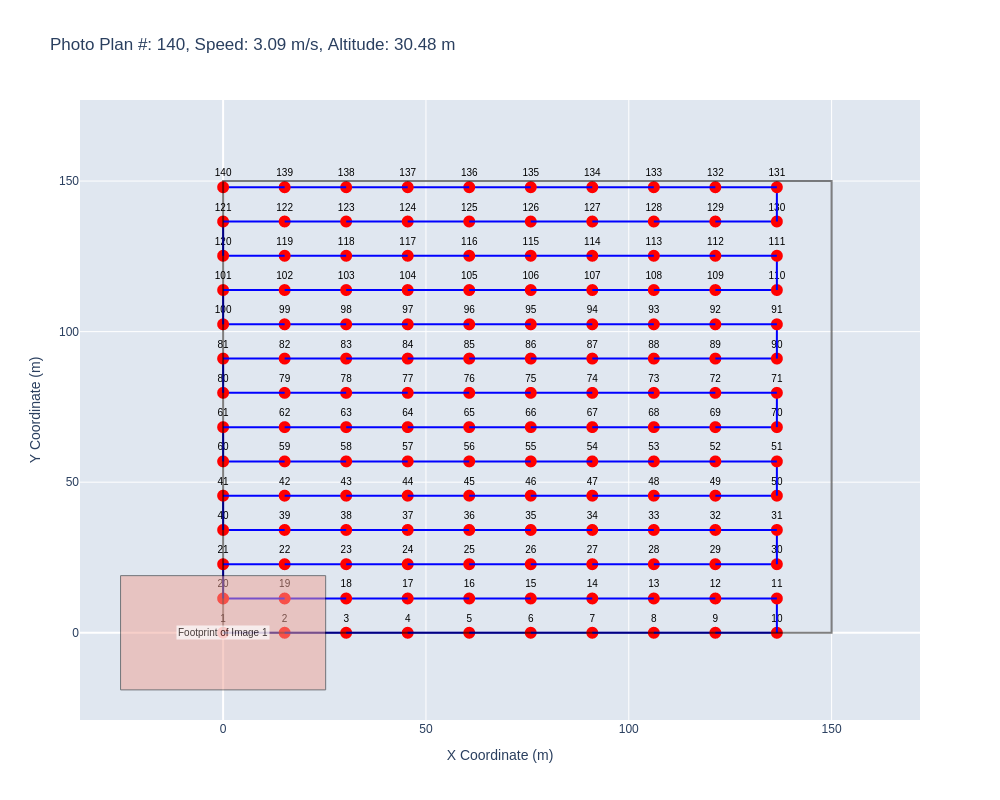

In [23]:
fig = plot_photo_plan(computed_plan, dataset_spec.scan_dimension_x, dataset_spec.scan_dimension_y)
fig.show("png")

$\color{red}{\text{TODO: }}$ Compute the following ablations (and any other you can think of)

1. Change overlap and confirm it affects the consecutive images
2. Change sidelap and confirm it does not affect the consecutive images
3. Change the height of the scan and document the affect on scan plans
4. Change exposure time

### 1. Change overlap and confirm it affects the consecutive images

Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144)
DatasetSpec(overlap=0.35, sidelap=0.7, height=30.48, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=2, gimbal_x_deg=0, gimbal_y_deg=0)


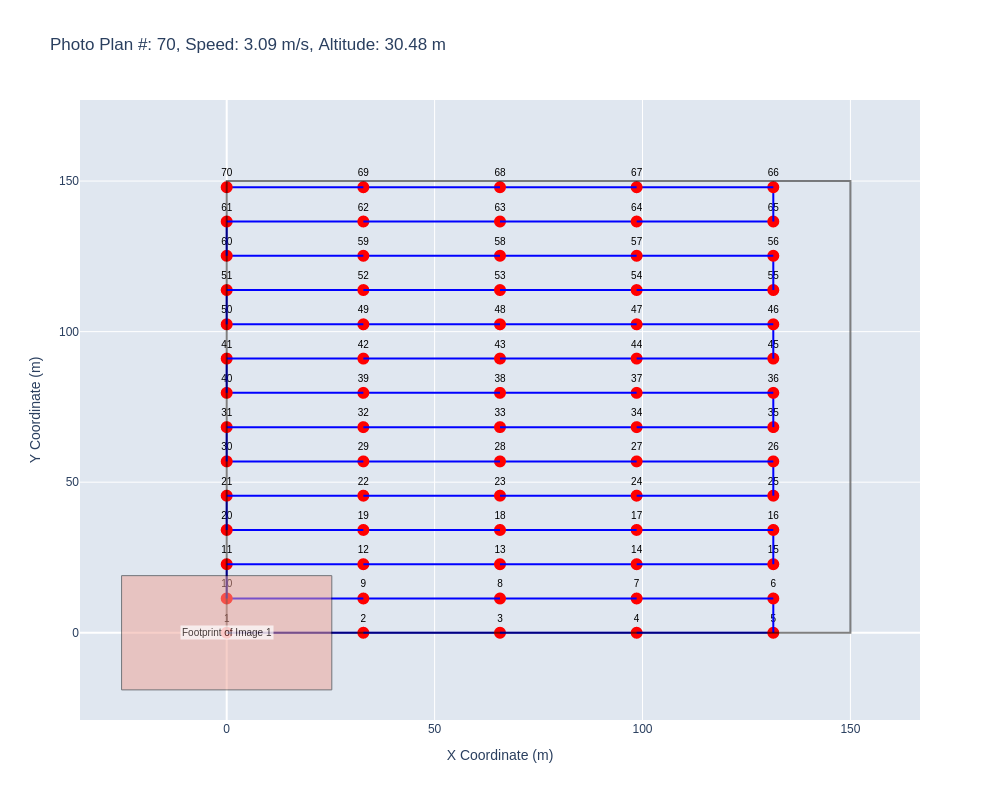

In [24]:
camera1 = copy.deepcopy(camera_x10)
dataset_spec1 = copy.deepcopy(dataset_spec)

dataset_spec1.overlap = 0.35

print(camera1)
print(dataset_spec1)

fig = plot_photo_plan(generate_photo_plan_on_grid(camera1, dataset_spec1), dataset_spec1.scan_dimension_x, dataset_spec1.scan_dimension_y)
fig.show("png")

# The overlap percentage affects the distance between images in the photo plan.

### 2. Change sidelap and confirm it does not affect the consecutive images

Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144)
DatasetSpec(overlap=0.7, sidelap=0.35, height=30.48, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=2, gimbal_x_deg=0, gimbal_y_deg=0)


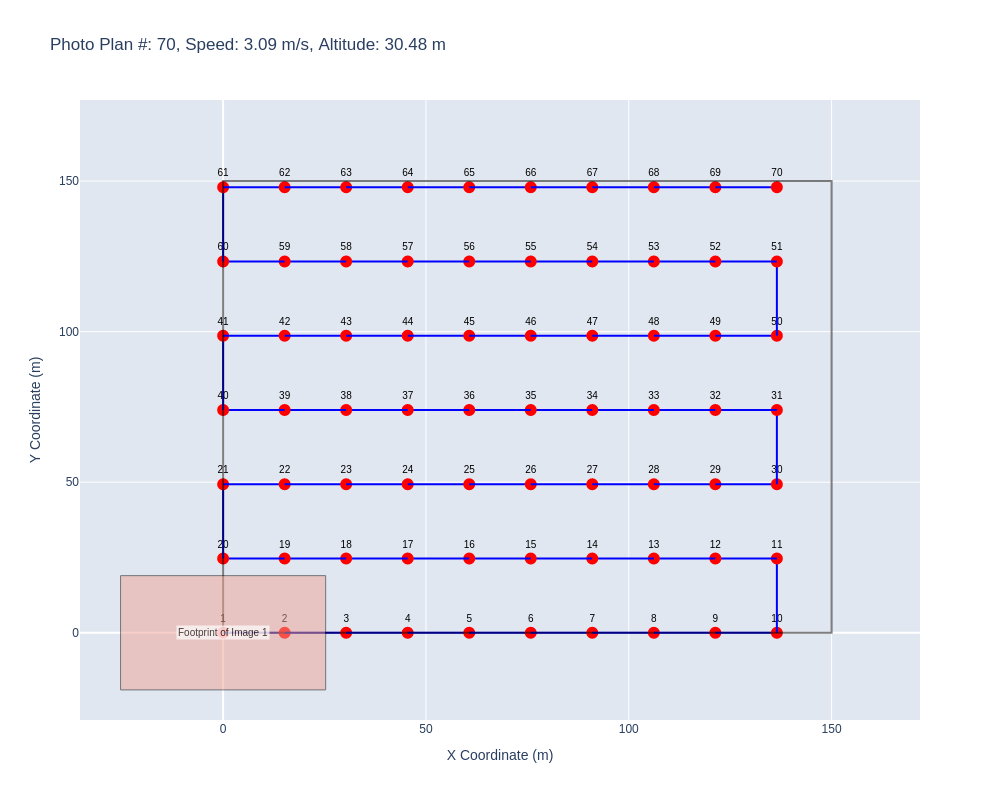

In [25]:
camera2 = copy.deepcopy(camera_x10)
dataset_spec2 = copy.deepcopy(dataset_spec)

dataset_spec2.sidelap = 0.35

print(camera2)
print(dataset_spec2)

fig = plot_photo_plan(generate_photo_plan_on_grid(camera2, dataset_spec2), dataset_spec2.scan_dimension_x, dataset_spec2.scan_dimension_y)
fig.show("png")

# The sidelap percentage affects the distance between images in the photo plan.

### 3. Change the height of the scan and document the affect on scan plans

Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144)
DatasetSpec(overlap=0.7, sidelap=0.7, height=15.24, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=2, gimbal_x_deg=0, gimbal_y_deg=0)


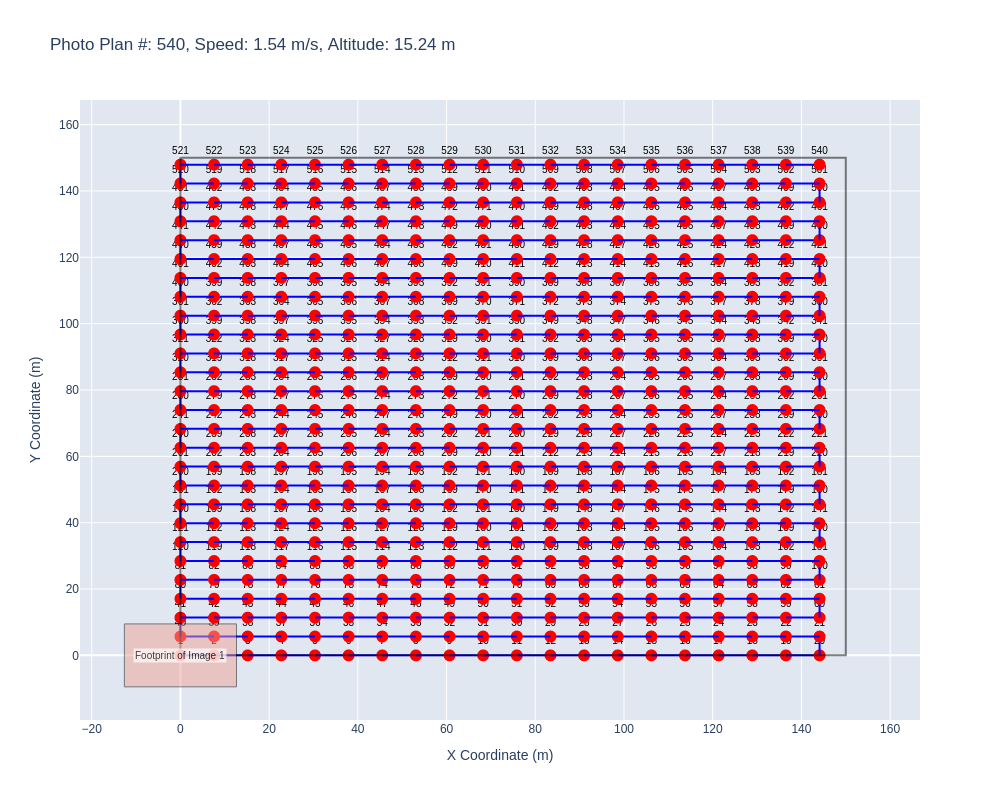

In [26]:
camera3 = copy.deepcopy(camera_x10)
dataset_spec3 = copy.deepcopy(dataset_spec)

dataset_spec3.height = 30.48 / 2

print(camera3)
print(dataset_spec3)

fig = plot_photo_plan(generate_photo_plan_on_grid(camera3, dataset_spec3), dataset_spec3.scan_dimension_x, dataset_spec3.scan_dimension_y)
fig.show("png")

# Height affects the number of images as well as the speed at which photos are taken
# if the height is scaled by x, the speed will be scaled by 1/x

### 4. Change exposure time

Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144)
DatasetSpec(overlap=0.7, sidelap=0.7, height=30.48, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=4, gimbal_x_deg=0, gimbal_y_deg=0)


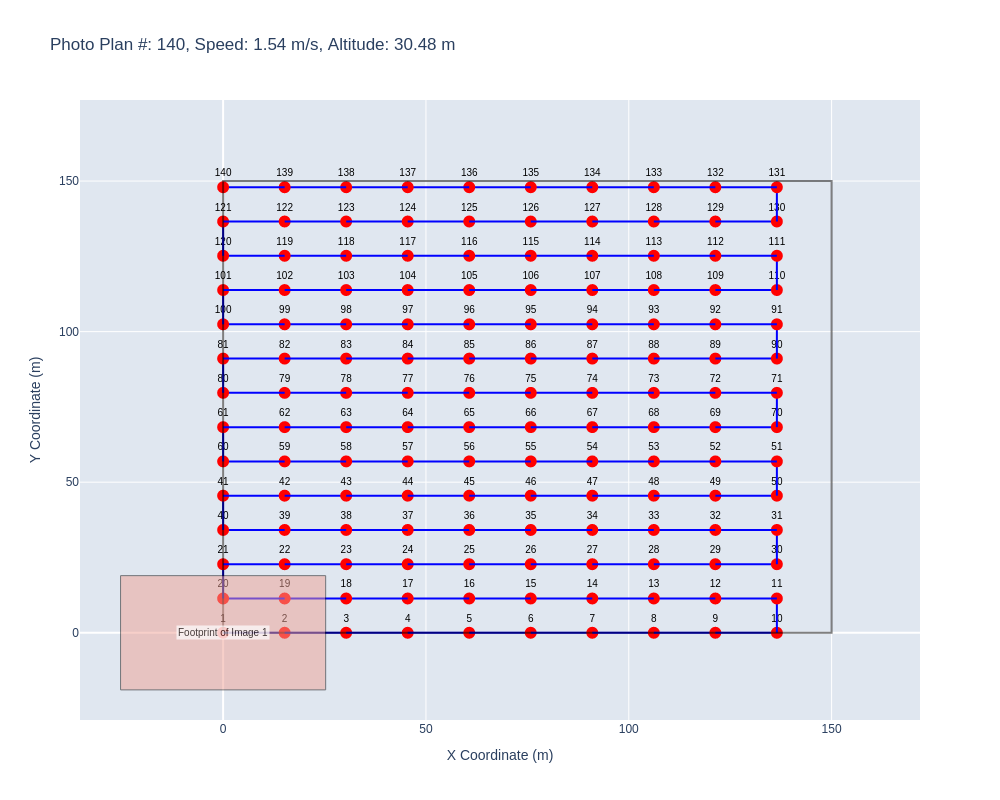

In [27]:
camera4 = copy.deepcopy(camera_x10)
dataset_spec4 = copy.deepcopy(dataset_spec)

dataset_spec4.exposure_time_ms = 4

print(camera4)
print(dataset_spec4)

fig = plot_photo_plan(generate_photo_plan_on_grid(camera4, dataset_spec4), dataset_spec4.scan_dimension_x, dataset_spec4.scan_dimension_y)
fig.show("png")

# exposure time directly affects the speed at which photos are taken
# if exposure time scaled by x, the speed will be scaled by 1/x

### 5. Photo plan for non-nadir images

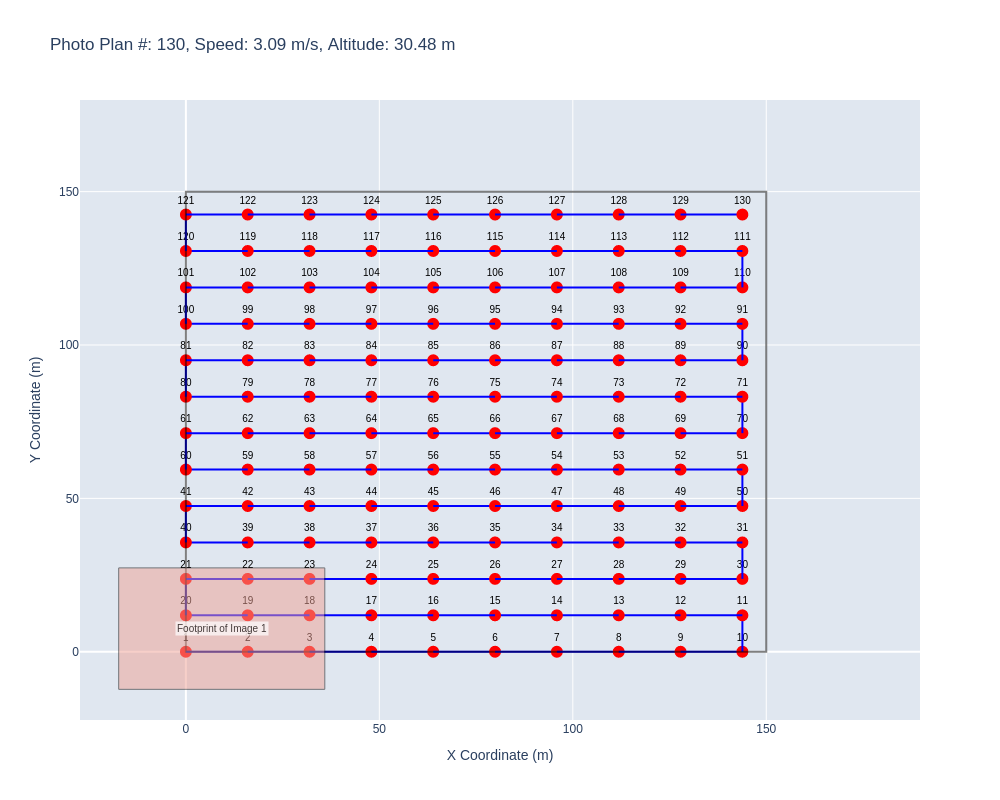

In [28]:
fig = plot_photo_plan(computed_plan_with_gimbal, dataset_spec_with_gimbal.scan_dimension_x, dataset_spec_with_gimbal.scan_dimension_y)
fig.show("png")


Camera(fx=4938.56, fy=4936.49, cx=4095.5, cy=3071.5, sensor_size_x_mm=13.107, sensor_size_y_mm=9.83, image_size_x_px=8192, image_size_y_px=6144)
DatasetSpec(overlap=0.7, sidelap=0.7, height=30.48, scan_dimension_x=150, scan_dimension_y=150, exposure_time_ms=2, gimbal_x_deg=20, gimbal_y_deg=25)


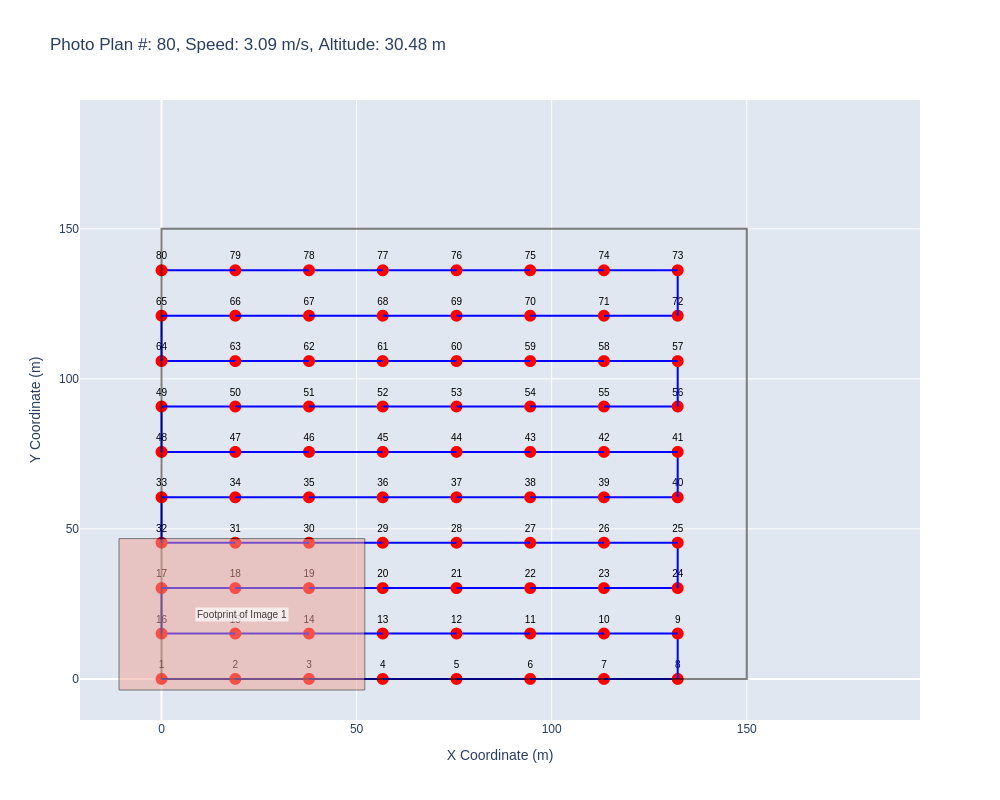

In [29]:
camera5 = copy.deepcopy(camera_x10)
dataset_spec5 = copy.deepcopy(dataset_spec)

dataset_spec5.gimbal_x_deg = 20
dataset_spec5.gimbal_y_deg = 25

print(camera5)
print(dataset_spec5)

fig = plot_photo_plan(generate_photo_plan_on_grid_with_gimbal_angle(camera5, dataset_spec5), dataset_spec5.scan_dimension_x, dataset_spec5.scan_dimension_y)
fig.show("png")

# as the gimbal angle changes, the foot print changes and the distance between images and number of images also changes